In [1]:
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress
import matplotlib
font = {'size'   : 12}

matplotlib.rc('font', **font)
import conntility


# Load spikes

In [4]:
import bluepysnap as bp
path_to_simulation = './'
s = bp.Simulation(path_to_simulation+'simulation_config.json') # Loads simulation object
# population_name = s.reports['lfp_report'].population_names[0]

# r  = s.reports['lfp_report'][population_name]

# Samples cells from exemplary regions and gets scaling factors

In [5]:
circuit = s.circuit

In [6]:
nodes = circuit.nodes

In [7]:
# Loads a generator that produces the cell types for all cells in forelimb, hindlimb, and upper lip regions

nFl = nodes.get('S1FL',properties=['mtype'])
# nHl = nodes.get('S1HL',properties=['mtype'])
# nULp = nodes.get('S1ULp',properties=['mtype'])

In [8]:
# Loads node ids for Layer 5 TPC:A cells from each of the above regions

Fl = next(nFl)[1]
Fl = np.array(list(Fl[Fl['mtype']=='L5_TPC:A'].index))[:,1].astype(int)

# Hl = next(nHl)[1]
# Hl = np.array(list(Hl[Hl['mtype']=='L5_TPC:A'].index))[:,1].astype(int)

# ULp = next(nULp)[1]
# ULp = np.array(list(ULp[ULp['mtype']=='L5_TPC:A'].index))[:,1].astype(int)

In [9]:
import h5py

In [10]:
# Loads the weights file

coeffsFile = "coeffs_neuropixels.h5"

coeffs = h5py.File(coeffsFile)

In [11]:
# Node ids from weights file
allNodeIds = coeffs['S1nonbarrel_neurons']['node_ids']

In [12]:
allNodeIds

<HDF5 dataset "node_ids": shape (211712,), type "<i8">

In [13]:
# Finds indices in the weights file of nodes in the selected regions

flIndex = np.where(np.isin(allNodeIds[:],Fl))[0]
# hlIndex = np.where(np.isin(allNodeIds[:],Hl))[0]
# ulpIndex = np.where(np.isin(allNodeIds[:],ULp))[0]


In [14]:
np.random.seed(1776)

# Samples nodes from the selected regions

flIndex = np.sort(np.random.choice(flIndex,1000,replace=False))
# hlIndex = np.sort(np.random.choice(hlIndex,1000,replace=False))
# ulpIndex = np.sort(np.random.choice(ulpIndex,1000,replace=False))

FLshort = allNodeIds[:][flIndex]
# HLshort = allNodeIds[:][hlIndex]
# ULPshort = allNodeIds[:][ulpIndex]


In [15]:
# Finds offsets for the compartment weights for the selected nodes

flOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex+1]]
# hlOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][hlIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][hlIndex+1]]
# ulpOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][ulpIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][ulpIndex+1]]


In [34]:
# Gets compartment weights for the selected nodes (shifted such that the minimum weight for each neuron is 0)

scaleFacFl = []
scaleFacHl = []
scaleFacULp = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,100]
    sfl -= np.min(sfl)
    
    # shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,1]
    # shl -= np.min(shl)
    
    # sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,1]
    # sulp -= np.min(sulp)

    scaleFacFl.append( sfl )
    # scaleFacHl.append( shl )
    # scaleFacULp.append( sulp )

# scaleFacFlEcog = []
# scaleFacHlEcog = []
# scaleFacULpEcog = []

# for i in range(len(flOffsets[0])):
    
#     sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,0]
#     sfl -= np.min(sfl)
    
#     shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,0]
#     shl -= np.min(shl)
    
#     sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,0]
#     sulp -= np.min(sulp)

#     scaleFacFlEcog.append( sfl )
#     scaleFacHlEcog.append( shl )
#     scaleFacULpEcog.append( sulp )



In [17]:
nanidx = np.where(np.isnan(coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][:,0]))[0]

In [18]:
nanidx

array([], dtype=int64)

In [52]:
coeffs['S1nonbarrel_neurons']['node_ids'][0]

0

# Loads 3d positions

In [19]:
path_to_positions = "positions/"


In [20]:
p = pd.read_pickle(path_to_positions+'0'+'/'+file)

NameError: name 'file' is not defined

In [21]:
# Loads positions for a subset of the selected nodes

allIds = [FLshort]#, HLshort, ULPshort]

allIds = [s for item in allIds for s in item]

allIds = np.array(allIds)

import os

i = 0

for subfolder in os.listdir(path_to_positions):
    for file in os.listdir(path_to_positions+subfolder):
        
        if i > 10:
            break
        
        positions = pd.read_pickle(path_to_positions+subfolder+'/'+file)
        
        columns = np.array(list(positions.columns))[:,0]
        
        indices = np.where(np.isin(allIds,columns))[0]
        
        if len(indices)==0:
            continue
        
        idsInFile = allIds[indices]

        positions = positions[idsInFile]
        
        if i == 0:
            allPositions = positions
        else:
            allPositions = pd.concat((allPositions,positions),axis=1)
            
        i += 1
        

In [22]:
ids = np.unique(np.array(list(allPositions.columns))[:,0])

In [23]:
def getNeuronSegmentMidpts(position):
    '''
    Gets midpoints for a single neuron
    '''

    
    secIds = np.array(list(position.columns))
    uniqueSecIds = np.unique(secIds)

    for sId in uniqueSecIds: # Iterates through sections

        pos = position.iloc[:,np.where(sId == secIds)[0]]

        if sId == 0: # Implies that section is a soma, so we just take the position from the file

            newPos = pos
 
        elif np.shape(pos.values)[-1] == 1: # If there is only one point in the section, we just take the value
            newPos = pd.concat((newPos,pos),axis=1)

        else: # We take the midpoints of the values in the file, which are the endpoints of the segments
            pos = (pos.iloc[:,:-1]+pos.iloc[:,1:])/2

            newPos = pd.concat((newPos,pos),axis=1)

    return newPos

In [24]:
# Spatial positions of the electrodes

ecog = np.array([3996,-777,-308.95])
eeg = np.array([3996,-777,2423.97])
returnElectrode = np.array([2677,851,2947.32])
lfp = np.array([3996,-777,-1308.95])

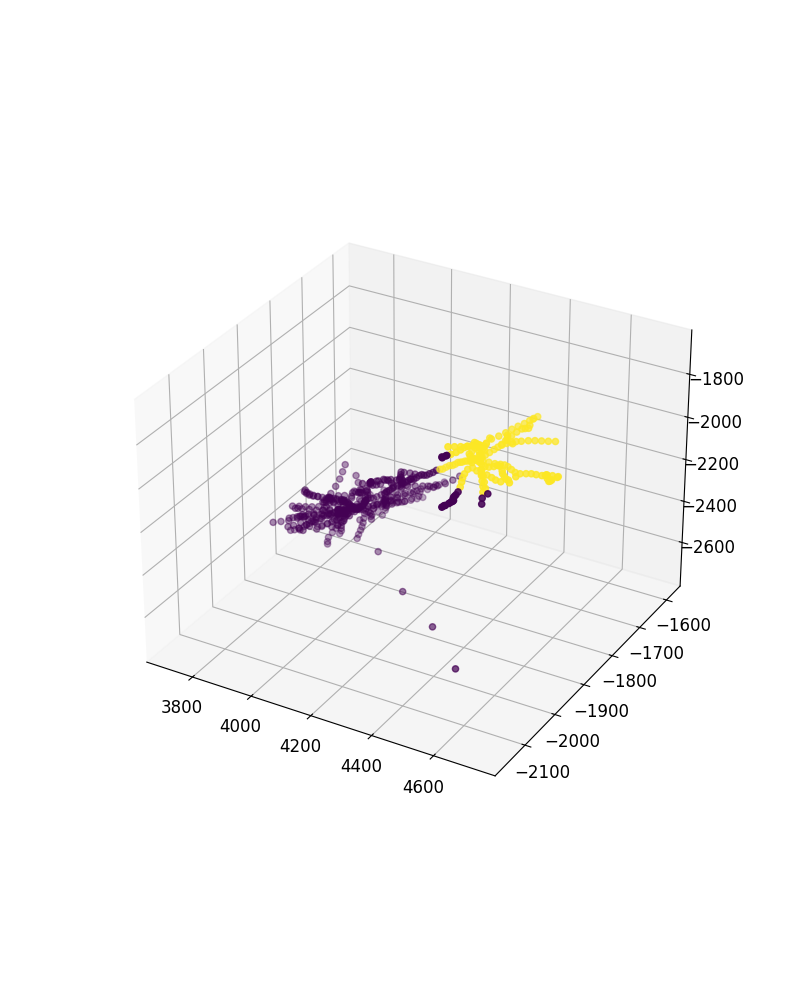

In [35]:
from matplotlib.gridspec import GridSpec


import types

plt.rcParams['axes.formatter.useoffset'] = False

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(projection='3d')

# gs = GridSpec(4, 6, figure=fig)
# ax1 = fig.add_subplot(gs[:-2, 0:3],projection='3d')
# ax2 = fig.add_subplot(gs[:-2, 3:],projection='3d')
# ax3 = fig.add_subplot(gs[-2, 0:2])
# ax4 = fig.add_subplot(gs[-2, 2:4])
# ax5 = fig.add_subplot(gs[-2, 4:])
# ax6 = fig.add_subplot(gs[-1, 0:2])
# ax7 = fig.add_subplot(gs[-1, 2:4])
# ax8 = fig.add_subplot(gs[-1, 4:])

#####
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG
for i in ids[5:]:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFl
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHl
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax1.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=1e-7)

    break

    
# ax1.view_init(elev=9., azim=-85)

# # Plots locations of electrodes
# ax1.scatter(eeg[0],eeg[1],eeg[2],c='r',s=20)
# ax1.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20) 

# ax1.set_xlim((2801.1161576783625, 6260.576980695542))
# ax1.set_ylim((-2284.337284947517, 1883.8635116069354))
# ax1.set_zlim((-4332.110601382281, 914.4962633882312))

# ax1.set_title('A',ha='left', x=-0)

# ax1.axis('off')

# cb = plt.colorbar(im,fraction=0.25,location='bottom')

# cb.set_label(label='Compartment weights (V/nA)',labelpad=20)
# cb.set_ticks([])
# #####



# Differences between methods

In [33]:
# Loads compartment weights for LFP for eaach selected region

scaleFacFlLfp = []
scaleFacHlLfp = []
scaleFacULpLfp = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,2]
    sfl -= np.min(sfl)
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,2]
    shl -= np.min(shl)
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,2]
    sulp -= np.min(sulp)

    scaleFacFlLfp.append( sfl )
    scaleFacHlLfp.append( shl )
    scaleFacULpLfp.append( sulp )

In [34]:
# Loads compartment weights calculted with dipole method, for ECoG

scaleFacFlDipoleEcog = []
scaleFacHlDipoleEcog = []
scaleFacULpDipoleEcog = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,3]
    sfl -= np.min(sfl[0])
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,3]
    shl -= np.min(shl[0])
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,3]
    sulp -= np.min(sulp[0])

    scaleFacFlDipoleEcog.append( sfl )
    scaleFacHlDipoleEcog.append( shl )
    scaleFacULpDipoleEcog.append( sulp )

In [35]:
# Loads compartment weights calculted with dipole method, for EEG

scaleFacFlDipole = []
scaleFacHlDipole = []
scaleFacULpDipole = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,4]
    sfl -= np.min(sfl)
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,4]
    shl -= np.min(shl)
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,4]
    sulp -= np.min(sulp)

    scaleFacFlDipole.append( sfl )
    scaleFacHlDipole.append( shl )
    scaleFacULpDipole.append( sulp )

In [36]:
# Loads compartment weights calculted with dipole method, for LFP

scaleFacFlDipoleLfp = []
scaleFacHlDipoleLfp = []
scaleFacULpDipoleLfp = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,5]
    sfl -= np.min(sfl)
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,5]
    shl -= np.min(shl)
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,5]
    sulp -= np.min(sulp)

    scaleFacFlDipoleLfp.append( sfl )
    scaleFacHlDipoleLfp.append( shl )
    scaleFacULpDipoleLfp.append( sulp )

The following cell produces Figure 5:

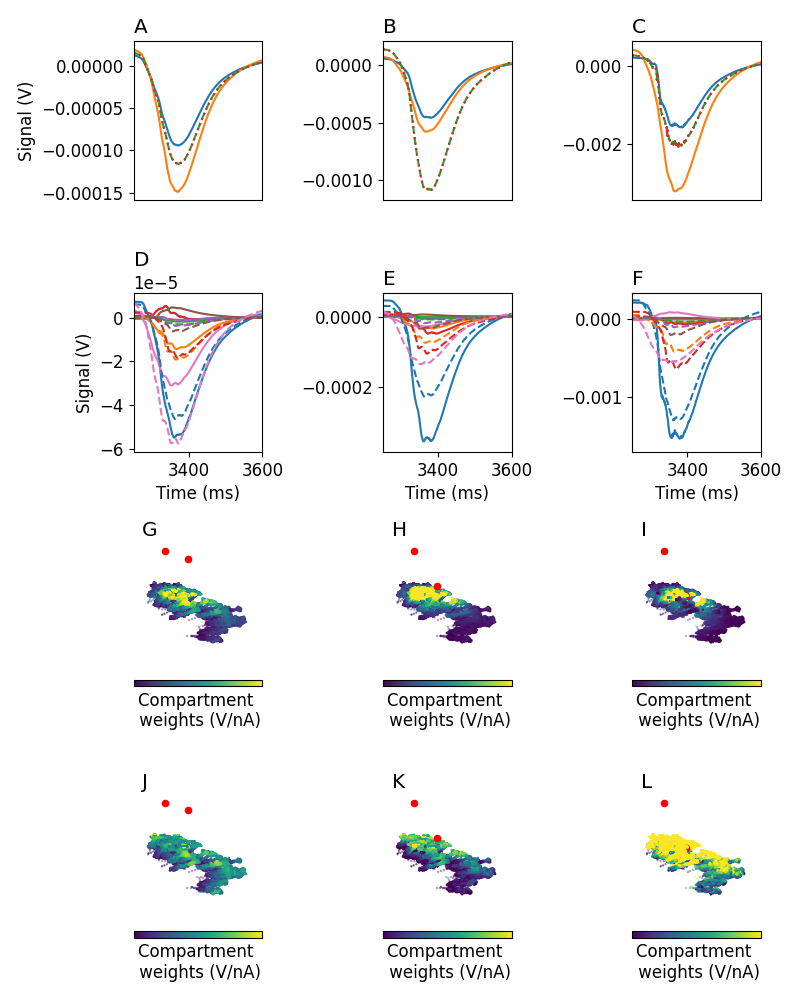

In [38]:
fig = plt.figure(figsize=(8,10))

############
# Plot EEG signals, calculated with each method
ax = plt.subplot(4,3,1)

plt.plot(signalTotal['Forelimb_EEG_Reciprocity']-np.mean(signalTotal['Forelimb_EEG_Reciprocity']))
plt.plot(signalTotal['Forelimb_EEG_Dipole']-np.mean(signalTotal['Forelimb_EEG_Dipole']))
plt.plot(signalTotal['Forelimb_EEG_PointSource']-signalTotal['Reference_PointSource']-np.mean(signalTotal['Forelimb_EEG_PointSource']-signalTotal['Reference_PointSource']),'--')
plt.plot(signalTotal['Forelimb_EEG_LineSource']-signalTotal['Reference_LineSource']-np.mean(signalTotal['Forelimb_EEG_LineSource']-signalTotal['Reference_LineSource']),':')
plt.xticks(visible=False)
plt.xlim([3250,3600])
plt.ylabel('Signal (V)')
plt.xticks([])
ax.set_title('A',ha='left', x=-0)
plt.tight_layout()

ax = plt.subplot(4,3,2)

# Plots ECoG Signals, calculated with each method
plt.plot(signalTotal['Forelimb_ECoG_Reciprocity']-np.mean(signalTotal['Forelimb_ECoG_Reciprocity']))
plt.plot(signalTotal['Forelimb_ECoG_Dipole']-np.mean(signalTotal['Forelimb_ECoG_Dipole']))
plt.plot(signalTotal['Forelimb_ECoG_PointSource']-signalTotal['Reference_PointSource']-np.mean(signalTotal['Forelimb_ECoG_PointSource']-signalTotal['Reference_PointSource']),'--')
plt.plot(signalTotal['Forelimb_ECoG_LineSource']-signalTotal['Reference_LineSource']-np.mean(signalTotal['Forelimb_ECoG_LineSource']-signalTotal['Reference_LineSource']),':')
plt.xticks(visible=False)
plt.xlim([3250,3600])
plt.xticks([])
ax.set_title('B',ha='left', x=-0)
plt.tight_layout()

ax = plt.subplot(4,3,3)

# Plots LFP Signals, claculated with each method
plt.plot(signalTotal['Forelimb_LFP_Reciprocity']-np.mean(signalTotal['Forelimb_LFP_Reciprocity']))
plt.plot(signalTotal['Forelimb_LFP_Dipole']-np.mean(signalTotal['Forelimb_LFP_Dipole']))
plt.plot(signalTotal['Forelimb_LFP_PointSource']-signalTotal['Reference_PointSource']-np.mean(signalTotal['Forelimb_LFP_PointSource']-signalTotal['Reference_PointSource']),'--')
plt.plot(signalTotal['Foreelimb_LFP_LineSource']-signalTotal['Reference_LineSource']-np.mean(signalTotal['Foreelimb_LFP_LineSource']-signalTotal['Reference_LineSource']),':')
plt.xticks([])
plt.xlim([3250,3600])
ax.set_title('C',ha='left', x=-0)
plt.tight_layout()
####################

# Plots contribution of each region to EEG signals, calculated with Reciprocity and Dipole methods
ax = plt.subplot(4,3,4)

for i, region in enumerate(regions):
    plt.plot(byRegion[region]['Forelimb_EEG_Reciprocity']-np.mean(byRegion[region]['Forelimb_EEG_Reciprocity']),c='C'+str(i))

for i, region in enumerate(regions):   
    plt.plot(byRegion[region]['Forelimb_EEG_Dipole']-np.mean(byRegion[region]['Forelimb_EEG_Dipole']),'--',c='C'+str(i))

plt.xlim([3250,3600])
ax.set_title('D',ha='left', x=-0)
plt.ylabel('Signal (V)')
plt.xlabel('Time (ms)')
plt.tight_layout()

###############
# Plots contribution of each region to ECoG signals, calculated with Reciprocity and Dipole methods
ax = plt.subplot(4,3,5)

for i, region in enumerate(regions):
    plt.plot(byRegion[region]['Forelimb_ECoG_Reciprocity']-np.mean(byRegion[region]['Forelimb_ECoG_Reciprocity']),c='C'+str(i))

for i, region in enumerate(regions):   
    plt.plot(byRegion[region]['Forelimb_ECoG_Dipole']-np.mean(byRegion[region]['Forelimb_ECoG_Dipole']),'--',c='C'+str(i))

plt.xlim([3250,3600])
ax.set_title('E',ha='left', x=-0)
plt.xlabel('Time (ms)')
plt.tight_layout()

###############
# Plots contribution of each region to LFP signals, calculated with Reciprocity and Dipole methods
ax = plt.subplot(4,3,6)

for i, region in enumerate(regions):
    plt.plot(byRegion[region]['Forelimb_LFP_Reciprocity']-np.mean(byRegion[region]['Forelimb_LFP_Reciprocity']),c='C'+str(i))

for i, region in enumerate(regions):   
    plt.plot(byRegion[region]['Forelimb_LFP_Dipole']-np.mean(byRegion[region]['Forelimb_LFP_Reciprocity']),'--',c='C'+str(i))


plt.xlim([3250,3600])
ax.set_title('F',ha='left', x=-0)
plt.xlabel('Time (ms)')
plt.tight_layout()
###############################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG, calculated with reciprocity method

ax = fig.add_subplot(4,3,7,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFl
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHl
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-9,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(eeg[0],eeg[1],eeg[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('G',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for ECoG, calculated with reciprocity method

ax = fig.add_subplot(4,3,8,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlEcog
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlEcog
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpEcog
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values

    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=15e-9,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(ecog[0],ecog[1],ecog[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('H',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for LFP, calculated with reciprocity method
ax = fig.add_subplot(4,3,9,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlLfp
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlLfp
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpLfp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values

    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-8,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(lfp[0],lfp[1],lfp[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('I',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################

#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG, calculated with dipole method

ax = fig.add_subplot(4,3,10,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlDipole
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlDipole
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpDipole
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-9,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(eeg[0],eeg[1],eeg[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('J',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for ECoG, calculated with dipole method

ax = fig.add_subplot(4,3,11,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlDipoleEcog
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlDipoleEcog
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpDipoleEcog
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=15e-9,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(ecog[0],ecog[1],ecog[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('K',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for LFP, calculated with dipole method
ax = fig.add_subplot(4,3,12,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlDipoleLfp
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlDipoleLfp
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpDipoleLfp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-8,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(lfp[0],lfp[1],lfp[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('L',ha='left', x=0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))

plt.savefig('figures/compareDipole.png',dpi=300)